In [2]:
import torch
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import os

from pred_live import create_overlapping_parquets, load_radio_dataset, prepare_ecallisto_datasets, prepare_dataloaders, create_logits, sigmoid, load_model, hf_hub_download
from datasets import load_dataset



/home/vincenzo/miniconda3/envs/flaresense-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from app import BASE_PATH
from pred_live import REPO_ID, MODEL_FILENAME, CONFIG_PATH

checkpoint_path = hf_hub_download(repo_id=REPO_ID, filename=MODEL_FILENAME)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
print(f"Using checkpoint: {checkpoint_path}")
print(f"Using config: {CONFIG_PATH}")
print(f"Using model from {REPO_ID}")

# Load model
model, config = load_model(checkpoint_path, CONFIG_PATH)

# Put model on device
model.to(device)

Using device: cpu
Using checkpoint: /home/vincenzo/.cache/huggingface/hub/models--i4ds--flaresense-v2/snapshots/43dca6443c7c8205e8e3d3a077f0942e50a950ee/model.ckpt
Using config: configs/best_v2.yml
Using model from i4ds/flaresense-v2


GrayScaleResNet(
  (recall): BinaryRecall()
  (precision): BinaryPrecision()
  (f1_score): BinaryF1Score()
  (confmat): BinaryConfusionMatrix()
  (resnet): OptimizedModule(
    (_orig_mod): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
    

In [4]:
start_datetime = datetime(2024, 12, 15)
end_datetime = start_datetime + timedelta(hours=4)

INSTRUMENT_LIST = ['ASSA']
tmp_dir = 'tmp'

In [5]:
# Or load the test dataset
# Change patch of the dataset
ds_test = load_dataset("i4ds/ecallisto_radio_sunburst", split='test', cache_dir='/mnt/nas05/data01/vincenzo/hu')

In [6]:
ds_test_e = prepare_ecallisto_datasets(ds_test, config)

In [7]:
data_loader = prepare_dataloaders(ds_test_e, 32)
preds = create_logits(model, data_loader)

  0%|          | 0/955 [00:00<?, ?it/s]

Image tensor saved as PNG for index 0


100%|██████████| 955/955 [09:09<00:00,  1.74it/s]


In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [9]:
preds = np.array(preds)
probs = sigmoid(preds)
pred_label = np.where(probs > 0.5, 1, 0)
correct = np.where(pred_label == ds_test[config['data']['test_label_name']], 1, 0)
ds_test = ds_test.add_column("pred", preds)
ds_test = ds_test.add_column('correct', correct)
ds_test = ds_test.add_column('pred_label', pred_label)

# To dataframe for easier processing
df_tests = ds_test.to_pandas()


In [10]:
# To dataframe for easier processing
df_tests = ds_test.remove_columns(['image']).to_pandas()


In [11]:
print(f"Bursts: {df_tests['pred_label'].sum()}")
print(f"Correct: {df_tests['correct'].sum()}")

Bursts: 3027
Correct: 29114


In [12]:
from PIL import Image
import io

In [13]:
# 5498 is nice

In [14]:
from captum.attr import GradientShap, IntegratedGradients
from captum.attr import visualization as viz
from datetime import timedelta

In [15]:
# Inverse model?
class InvertedModel(torch.nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model

    def forward(self, x):
        return -self.model(x)  # negate output to simulate class 0 score



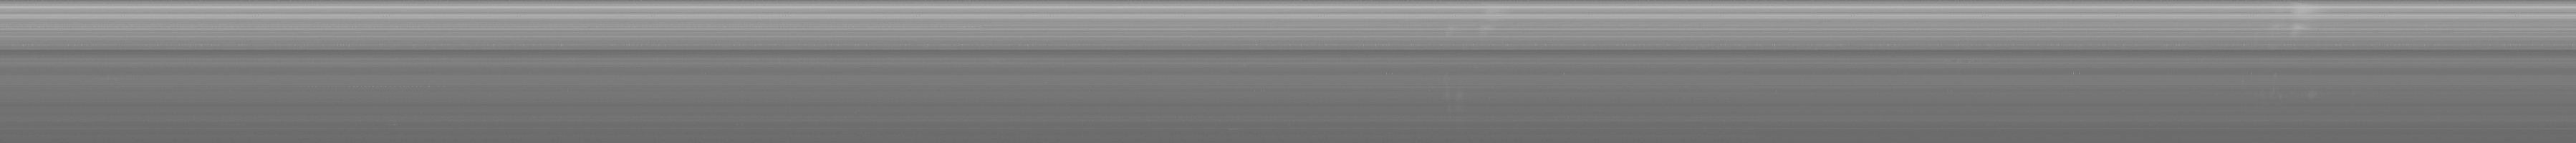

In [122]:
# Get random burst
is_burst = 1
is_correct = 1
example_idx = int(df_tests[(df_tests[config['data']['test_label_name']] == is_burst) & (df_tests['correct'] == is_correct)].sample(1).index[0])
example_burst = ds_test[example_idx]
example_burst


image = Image.open(io.BytesIO(example_burst['image']['bytes']))
image.show()

In [123]:
# Prepare the input tensor (assuming ds_e[IDX][0] is grayscale)
gray_img = ds_test_e[example_idx][0].squeeze(0)  # Single-channel grayscale image
start_datetime = ds_test[example_idx]['start_datetime']
end_datetime = start_datetime + timedelta(minutes=15)
antenna = ds_test[example_idx]['antenna']
pred = ds_test[example_idx]['pred_label']
gt = ds_test[example_idx]['manual_label']
input_tensor = gray_img
input_tensor.shape

##

ds_test[example_idx]

{'image': {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0e\x0c\x00\x00\x00\xc8\x08\x00\x00\x00\x00\xab\x11t\x9f\x00\x01\x00\x00IDATx\x9c\xbc\xfd\xcb\x92mI\x92\x1d\x88\xad\xa5f\xc7\xaf\xdf\xa8,4\x88\xe6\xdfr\xca\x19E(B\x11`\xd0B\x11\x0ez\x82\x01\xc7\xfc+\xa2[\x80\xcc\x8a\xb8\xeeg\x9b*\x07KU\xcd\xf6q\x8f\xac\x04X\xa4W\xe5\r\xf7s\xf6\xb6\x87\xbe_\xa6\xc6\xff\xd3\x05\x00\x98x<\xf5\x1b\xf0\x97\xbf\x01\x83O\x02\x0cL}\xfa\xf3w\x02\x8f\xc0B\xfc\xf8\x00\x00\xc6|\xff\x05\\\xc3\x11\x00@\x8ck\xce_\x00\xc0\x11\xf0`\x00\xc0\xcf?\xc6z\xff\x95\x03\x83\xa1\xff\x01\x00\xde\x7f1j\x86\x1f\x1f`\x00s\xc5\xbc\x1eqa^\x18\xe4\x13\xb4\x05\xcc\x0b\x18X\xc0X\x8c\xb1\xe6\x05`\xe2\xc2\xfb/\xfc\xfc\x03\x18\xab\x86\xc7\xbc\x00\xe2G\xce\xf7x\xe6\x9c\xef\xbf\xe6\xc5\x00\x83\xf1\xfek^\x8f\'0/\x06\xde\x7f\x01\xf8\xf1\xa1-\xc6\xe3\xe2\xf3\xc7\xc2\xfb/`p~L<\x01\xbe}p,\xadq^\x8c\xf7\x8f\x18\x8e\xc0\xbcr\xae\xc0\xed\x87\x83\xcfYp\x9c\xef\xff\x12\x00\xf0\xbe\xc6\xaf\x9f\x7f\xec\x87\xe65V\xc3a^\xc0\xfb\xe3o\xf7q\xfe

In [124]:
sigmoid(-1.9627923965454102)

0.12316516381893704

In [125]:
def img_to_baseline(tensor:  torch.Tensor, median=False):
    if median:
        return tensor.quantile(0.1, dim=1).repeat(512, 1).mT.unsqueeze(0).repeat(1, 3, 1, 1)
    else:
        return tensor.unsqueeze(0).repeat(1, 3, 1, 1)

In [126]:
gs = GradientShap(model)
# gs  = GradientShap(InvertedModel(model))
# We define a distribution of baselines and draw `n_samples` from that
# distribution in order to estimate the expectations of gradients across all baselines
input_ready = input_tensor.unsqueeze(0).repeat(1, 3, 1, 1)


In [127]:
#baselines = [img_to_baseline(ds_e[x][0].squeeze(), median=True) for x in range(100)]
#baselines_tensor = torch.cat(baselines, dim=0)
baselines_tensor = torch.zeros_like(input_ready)
baselines_tensor.shape

torch.Size([1, 3, 128, 512])

In [128]:
attributions, delta = gs.attribute(input_ready, stdevs=0.2, n_samples=100, baselines=baselines_tensor,
                                   target=0, return_convergence_delta=True)

In [129]:
def tensor_to_viz_input(tensor, minmax_scaling=False, gray_scale=False):
    if minmax_scaling:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    if tensor.size(0) > 3: # Batch dim missing
        tensor = tensor.unsqueeze(0)
    if tensor.size(1) == 1:
        tensor = tensor.expand(-1, 3, -1, -1)
    if gray_scale: 
        return np.transpose(tensor.squeeze(0).cpu().detach().numpy(), (1, 2, 0))[:, :, 0]
    return np.transpose(tensor.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [130]:
import pandas as pd
import matplotlib.dates as mdates


from ecallisto_ng.data_download.downloader import get_ecallisto_data
from ecallisto_ng.plotting.plotting import plot_spectrogram
from ecallisto_ng.data_processing.utils import subtract_constant_background

df = get_ecallisto_data(start_datetime, end_datetime, antenna)[antenna] #.columns.to_list()
freqs = df.columns.to_list()
plot_spectrogram(subtract_constant_background(df).clip(0, 16))

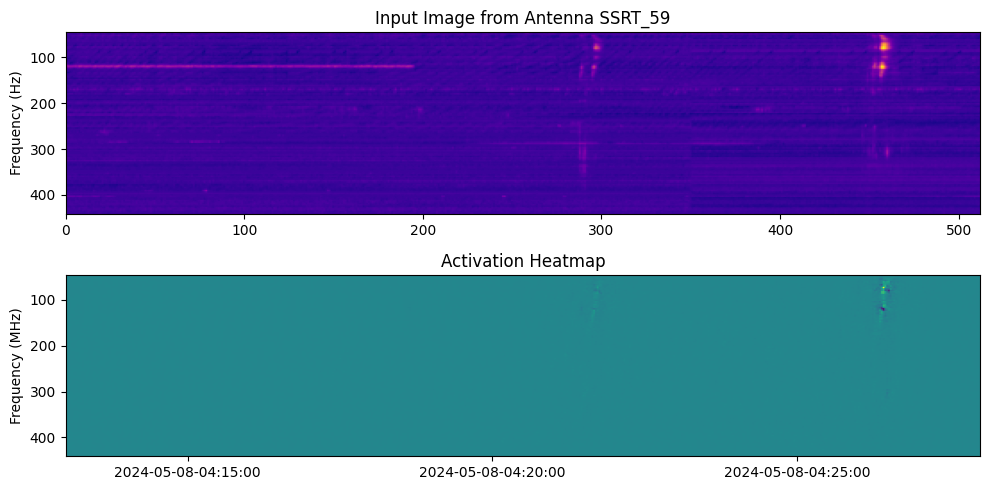

In [131]:
# Define frequency range (in Hz or whatever unit you're using)
min_freq = min(freqs)     # e.g., 20 Hz
max_freq = max(freqs)    # e.g., 20 kHz

fig, axs = plt.subplots(2, 1, figsize=(10, 5))  # 2 rows, 1 column


# Plot original image with frequency on y-axis
axs[0].imshow(
    tensor_to_viz_input(input_ready, minmax_scaling=True, gray_scale=True),
    cmap='plasma',
    aspect='auto',
    extent=[
        0,  # no datetime here — pixel range on x
        input_ready.shape[-1],
        max_freq,
        min_freq,
    ]
)
axs[0].set_title(f'Input Image from Antenna {antenna}')
axs[0].set_ylabel('Frequency (Hz)')

# Heatmap with datetime on x-axis and frequency on y-axis
im = axs[1].imshow(
    tensor_to_viz_input(attributions, minmax_scaling=True, gray_scale=True),
    cmap='viridis',
    aspect='auto',
    extent=[
        mdates.date2num(start_datetime),
        mdates.date2num(end_datetime),
        max_freq,
        min_freq,
    ],
    
)
axs[1].set_title('Activation Heatmap')
axs[1].set_ylabel('Frequency (MHz)')

# Format datetime x-axis
axs[1].xaxis_date()
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H:%M:%S'))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].tick_params(axis='x', rotation=0)


plt.tight_layout()
plt.show()


In [132]:
fig.savefig(f"XAI/heatmap_{example_idx}_{antenna}{'_burst' if is_burst else ''}{'_correct' if  is_correct else '_incorrect'}.png")

In [133]:
example_idx

26805